In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from Environment import Dealer, BlackjackEnv
from agent import QLearningAgent, ReinforceAgent
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns

In [2]:

dealer = Dealer()
dealer.create_playing_deck(D = np.inf)
#print last 10 cards in the deck
print(dealer.playing_deck[-10:])
print('deal five cards:')
#deal 5 cards 
for i in range(5):
    print(dealer.deal_card())
print('new upcoming cards:')
print(dealer.playing_deck[-10:]) 


inite deck
deal five cards:
('hearts', 9)
('hearts', 3)
('diamonds', 6)
('spades', 1)
('spades', 5)
new upcoming cards:
inite deck


# Watkins Q-Learning Agent 

For the case where the number of decks used to deal is infinite, We can make use of Watkins Q-Learning. This is a temporal difference method. 

The general method is as follows: 

1. An initial Q-table is created, giving hit and stick for all the hand values as equal (all have an initial Q-value of 0)
2. a hand is played, the Q-values are updated according the the update rule after each card is drawn. (Reward is only given after the hand is over is the player doesnt bust)
3. steps 1 and 2 are repeated and the Q_table is updated until the Q_values converge.
4. The learned Q-table is then the policy that the agent has learned to maximise its reward per-hand. 

Q update rule:
 $$Q(S,A) \to (1-\alpha)Q(S,A) + \alpha[R + \gamma \max_{a}Q(S',a)]$$

 In this case we can set the discount factor $\gamma$ = 1, as we are only interested in the reward after the hand has been played. $\alpha$ is the learning rate. 

The Q-values in the table represent the expected reward for a hand given a specific action and state. For example if the Q-value for hitting when the hand value is 13 is 153.2, the exepected or average reward for a hand given hitting on 13 is 153.2

Testing the Q learning agent for an infinite deck of cards 

In [115]:
#initialize agent for Q-learning
env = BlackjackEnv(D=np.inf)
q_agent = QLearningAgent(env, alpha=0.001, gamma=1, epsilon_end=0.01)

In [116]:
q_agent.env.reset_deck()
episode_reward = q_agent.run_episode_reward()
print('reward after one episode: ',episode_reward)
print('Q values: ', q_agent.Q_values)

average_reward = q_agent.learn(num_episodes=500000)
print('Average reward after 10000 episodes: ', average_reward)
print('Learned Q values: ', q_agent.Q_values)

reward after one episode:  441
Q values:  {(2, 'hit'): 0.0, (2, 'stick'): 0.0, (3, 'hit'): 0.0, (3, 'stick'): 0.0, (4, 'hit'): 0.0, (4, 'stick'): 0.0, (5, 'hit'): 0.0, (5, 'stick'): 0.0, (6, 'hit'): 0.0, (6, 'stick'): 0.0, (7, 'hit'): 0.0, (7, 'stick'): 0.0, (8, 'hit'): 0.0, (8, 'stick'): 0.0, (9, 'hit'): 0.0, (9, 'stick'): 0.0, (10, 'hit'): 0.0, (10, 'stick'): 0.0, (11, 'hit'): 0.0, (11, 'stick'): 0.0, (12, 'hit'): 0.0, (12, 'stick'): 0.0, (13, 'hit'): 0.0, (13, 'stick'): 0.0, (14, 'hit'): 0.0, (14, 'stick'): 0.0, (15, 'hit'): 0.0, (15, 'stick'): 0.0, (16, 'hit'): 0.0, (16, 'stick'): 0.0, (17, 'hit'): 0.0, (17, 'stick'): 0.0, (18, 'hit'): 0.0, (18, 'stick'): 0.0, (19, 'hit'): 0.0, (19, 'stick'): 0.0, (20, 'hit'): 0.0, (20, 'stick'): 0.0, (21, 'hit'): 0.0, (21, 'stick'): 0.441}
Episode 100 completed (0.02%). Moving Average Reward: 79.02
Episode 200 completed (0.04%). Moving Average Reward: 70.3
Episode 300 completed (0.06%). Moving Average Reward: 90.1
Episode 400 completed (0.08%). Mo

Visualise learnd policy (q-values)

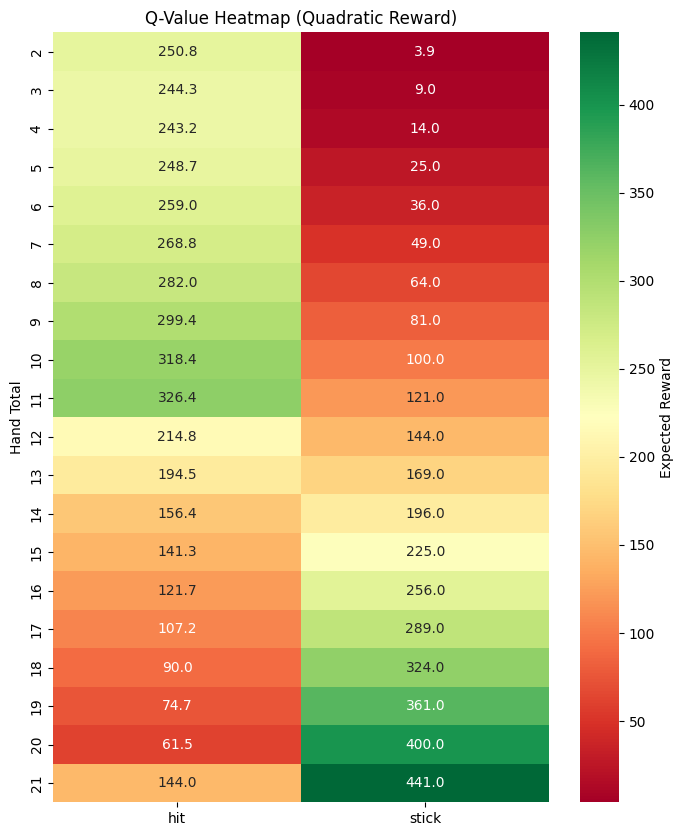

In [117]:
df = pd.Series(q_agent.Q_values).unstack()

df.index.name = 'Hand Total'
df = df.sort_index()

plt.figure(figsize=(8, 10))
sns.heatmap(df, annot=True, fmt=".1f", cmap="RdYlGn", cbar_kws={'label': 'Expected Reward'})
plt.title("Q-Value Heatmap (Quadratic Reward)")
plt.show()

Visualise the learning process:

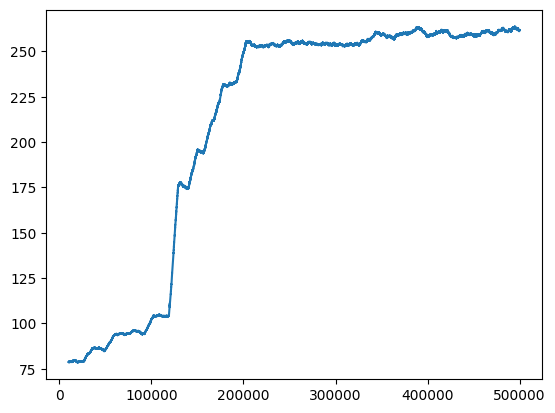

In [118]:
window_size = 10000
weights = np.ones(window_size) / window_size
moving_avg = np.convolve(average_reward, weights, mode='valid')
episodes = np.arange(window_size, len(average_reward) + 1)
plt.plot(episodes, moving_avg)

With a static epsilon, we see the reward increase jumping around and not reaching a very good level. To improve this we can introduce an epsilon decay throughout the learning process. This way the model can explore all the states often early in the training and as it learns what is effective it will explore less. 

We can use an exponential decay to decay $\epsilon$ from $\epsilon_{upper} = 1$ to $\epsilon_{lower} = 0.01$ during the training. 

$$\epsilon = \epsilon_{lower} + (\epsilon_{upper}-\epsilon_{lower})\exp(-10\frac{\text{episode iteratation}}{\text{total episodes}})$$

In [106]:
#initialize agent for Q-learning
env = BlackjackEnv(D=np.inf)
q_agent_edec = QLearningAgent(env, alpha=0.001, gamma=1, epsilon_end=0.01)

In [110]:
q_agent_edec.env.reset_deck()
episode_reward = q_agent_edec.play_hand_q_learning()
print('reward after one episode: ',episode_reward)
print('Q values: ', q_agent_edec.Q_values)

average_reward_edec = q_agent_edec.learn(num_episodes=500000,decay_epsilon=True)
print('Learned Q values: ', q_agent_edec.Q_values)

reward after one episode:  100
Q values:  {(2, 'hit'): 89.66561434207804, (2, 'stick'): 1.390703307153409, (3, 'hit'): 104.75251420328931, (3, 'stick'): 3.71983208373078, (4, 'hit'): 14.872829337470113, (4, 'stick'): 15.99333778903664, (5, 'hit'): 17.271959789165166, (5, 'stick'): 24.9946750501946, (6, 'hit'): 17.657774311917624, (6, 'stick'): 35.990202091150074, (7, 'hit'): 17.26022508860367, (7, 'stick'): 48.9892127565996, (8, 'hit'): 20.728611856529717, (8, 'stick'): 63.98708507621129, (9, 'hit'): 22.428761909804663, (9, 'stick'): 80.98145847820057, (10, 'hit'): 60.51669187032767, (10, 'stick'): 99.99999999998712, (11, 'hit'): 22.488097866483464, (11, 'stick'): 120.97672762646293, (12, 'hit'): 7.73425539555834, (12, 'stick'): 136.34510110607297, (13, 'hit'): 5.125724482870746, (13, 'stick'): 161.58625898321642, (14, 'hit'): 3.6801079696458583, (14, 'stick'): 117.84806218422263, (15, 'hit'): 1.6224203962368633, (15, 'stick'): 78.37383396635161, (16, 'hit'): 1.76098573218943, (16, 'st

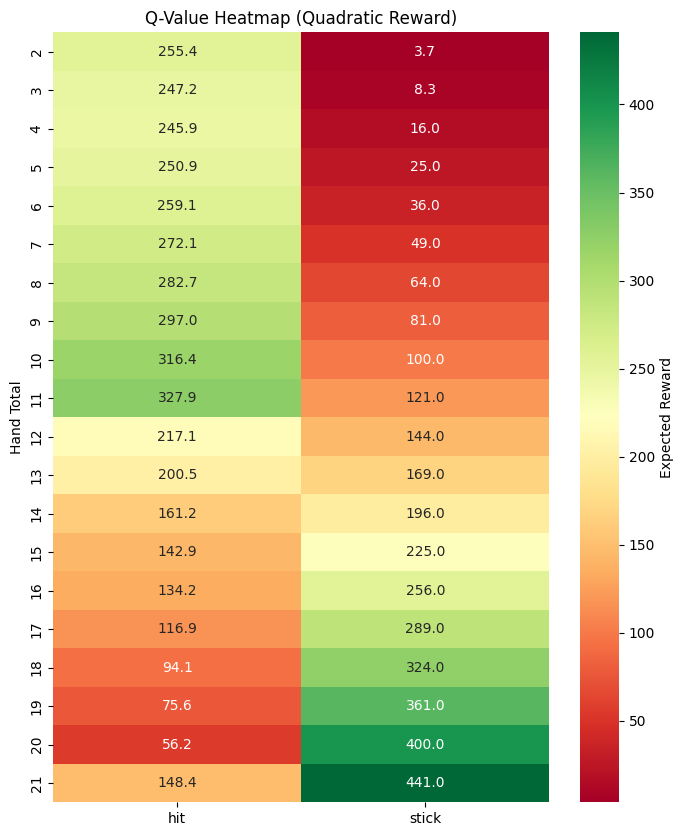

In [111]:
df = pd.Series(q_agent_edec.Q_values).unstack()

df.index.name = 'Hand Total'
df = df.sort_index()

plt.figure(figsize=(8, 10))
sns.heatmap(df, annot=True, fmt=".1f", cmap="RdYlGn", cbar_kws={'label': 'Expected Reward'})
plt.title("Q-Value Heatmap (Quadratic Reward)")
plt.show()

Text(0.5, 1.0, 'Q-Learning Agent Training Performance')

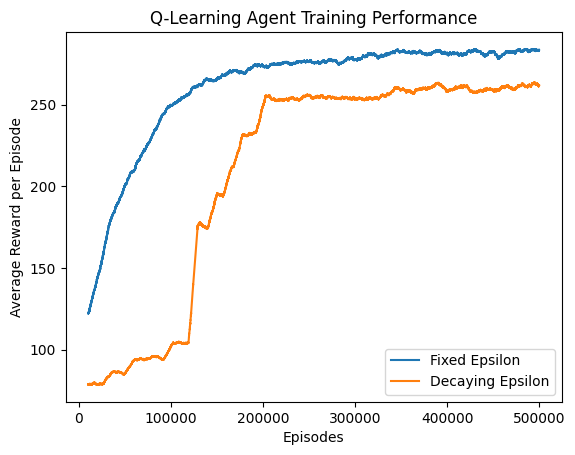

In [122]:
window_size = 10000
weights = np.ones(window_size) / window_size
moving_avg_edec = np.convolve(average_reward_edec, weights, mode='valid')
episodes = np.arange(window_size, len(average_reward_edec) + 1)
plt.plot(episodes, moving_avg_edec)
plt.plot(episodes, moving_avg)
plt.legend(['Fixed Epsilon','Decaying Epsilon'])
plt.xlabel('Episodes')
plt.ylabel('Average Reward per Episode')
plt.title('Q-Learning Agent Training Performance')

# REINFORCE LEARNING AGENT 

For the case where the number of decks is D < $\infty$ the problem becomes more complex; the state space is no longer just the value of the current hand, it now includes some history of the cards that have appeared. The method Q-learning will not be feasable since the state space will become too large when the number of decks is large. Instead we can use a policy gradient method since these make use of function approximation to map the state inputs to action probabilities.  

This function is effectively a linear model with a sigmoid function to give a probability of hitting or sticking, the training process will be using gradient acent (acent because we want to $\textbf{maximise}$ the reward) to update the parameters based on the reward throughout playing hands. 

We will need create a feature vector to represent the state space, for this case we will need 13 for how many of each each card type the agent has seen and 1 for the current value of the hand. So in total we will have a feature matrix of 14x1. 

We will create a parameterised policy, which is the linear model mentioned ealier. The models parameters will be updated according to:

$$\theta \to \theta + \alpha \gamma^{t}G\Delta_{\theta}log(A_t | S_t)$$

In [ ]:
env = BlackjackEnv(D=1)
r_agent = ReinforceAgent(env)
print(env.playing_deck)

[('diamonds', 5), ('diamonds', 4), ('hearts', 12), ('diamonds', 7), ('spades', 9), ('hearts', 1), ('hearts', 5), ('clubs', 12), ('diamonds', 1), ('diamonds', 13), ('clubs', 13), ('diamonds', 12), ('spades', 1), ('clubs', 2), ('diamonds', 6), ('spades', 1), ('clubs', 9), ('diamonds', 9), ('diamonds', 3), ('hearts', 13), ('diamonds', 7), ('spades', 3), ('diamonds', 1), ('spades', 7), ('clubs', 4), ('hearts', 13), ('hearts', 10), ('diamonds', 2), ('spades', 10), ('hearts', 8), ('hearts', 9), ('hearts', 2), ('spades', 12), ('clubs', 9), ('hearts', 1), ('hearts', 3), ('clubs', 13), ('clubs', 4), ('diamonds', 12), ('spades', 12), ('clubs', 6), ('clubs', 1), ('hearts', 11), ('diamonds', 11), ('clubs', 8), ('spades', 4), ('spades', 5), ('hearts', 10), ('spades', 8), ('hearts', 9), ('spades', 11), ('clubs', 11), ('diamonds', 9), ('hearts', 6), ('clubs', 10), ('clubs', 12), ('diamonds', 5), ('spades', 9), ('spades', 2), ('clubs', 7), ('spades', 6), ('diamonds', 3), ('clubs', 1), ('hearts', 11), 

In [9]:
hand_trajectory = r_agent.play_hand_reinforce()

print(r_agent.env.player_hand)
print(r_agent.state)

print('Hand trajectory (state, action, reward):\n', hand_trajectory)

[('spades', 12), ('clubs', 6)]
[0.76190476 0.         0.         0.         0.         1.
 1.         0.         0.         0.         1.         0.
 1.         0.         1.        ]
Hand trajectory (state, action, reward):
 [(array([0.47619048, 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 1.        , 0.        , 1.        ]), 'hit', 0, False), (array([0.76190476, 0.        , 0.        , 0.        , 0.        ,
       1.        , 1.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 1.        , 0.        , 1.        ]), 'stick', 256, True)]


In [10]:
final_traj = r_agent.run_episode()

final_state = final_traj[-1][0]
print('Final state of the episode:', final_state)

hand_values = [item[-1] for item in final_traj]
print('Hand values at the end of each hand in the episode:', hand_values)

Final state of the episode: [0.19047619 8.         8.         8.         8.         8.
 8.         8.         8.         8.         8.         8.
 8.         8.         1.        ]
Hand values at the end of each hand in the episode: [True, False, False, False, True, True, False, False, True, True, False, True, True, False, True, False, False, True, True, False, True, True, True, False, False, False, True, False, True, True, True, True, True, True, False, False, True, True, True, False, False, True, False, False, False, True, False, True, False, False, True, True, False, False, True, False, True, False, True, True, False, True, False, True, False, False, True, False, True, False, True, False, True, True, False, False, True, False, True, False, False, False, False, True, True]


In [129]:
env = BlackjackEnv(D=1)
r_agent = ReinforceAgent(env)
episode_reward = r_agent.train_agent(num_episodes=10000, learning_rate=0.001, gamma=0.99)

Episode 100 completed (1.00%). Average reward per hand: 100.3225806451613
Episode 200 completed (2.00%). Average reward per hand: 144.875
Episode 300 completed (3.00%). Average reward per hand: 190.6086956521739
Episode 400 completed (4.00%). Average reward per hand: 112.2258064516129
Episode 500 completed (5.00%). Average reward per hand: 132.5185185185185
Episode 600 completed (6.00%). Average reward per hand: 114.38709677419355
Episode 700 completed (7.00%). Average reward per hand: 137.8846153846154
Episode 800 completed (8.00%). Average reward per hand: 150.41666666666666
Episode 900 completed (9.00%). Average reward per hand: 210.69230769230768
Episode 1000 completed (10.00%). Average reward per hand: 164.0
Episode 1100 completed (11.00%). Average reward per hand: 141.06896551724137
Episode 1200 completed (12.00%). Average reward per hand: 143.30769230769232
Episode 1300 completed (13.00%). Average reward per hand: 127.16
Episode 1400 completed (14.00%). Average reward per hand: 

Text(0.5, 1.0, 'REINFORCE Agent Training Performance')

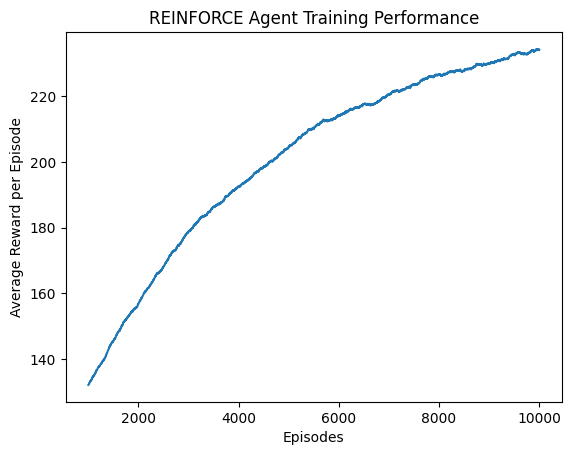

In [130]:
window_size = 1000
weights = np.ones(window_size) / window_size
moving_avg = np.convolve(episode_reward, weights, mode='valid')
episodes = np.arange(window_size, len(episode_reward) + 1)
plt.plot(episodes, moving_avg)
plt.xlabel('Episodes')
plt.ylabel('Average Reward per Episode')
plt.title('REINFORCE Agent Training Performance')

Since this is now quite computationaly expensive, We will implement ADAM to try and decrease convergence time: 

ADAM implments two key ideas that both use moving averages: 

1. Momentum, updates the step direction based on the direction we have been traveling
2. Velocity, updates the step size based on the magniute of acent we have been doing

These will smooth out the learning process and allow the model to converge quicker 

Implemting them in this model involves modifying the update rule: 

currently: 

$$\theta \to \theta + \alpha g_t$$

with $g_t = \gamma^{t}G\Delta_{\theta}log(A_t | S_t)$ 

This $g_t$ is then used to calculate the moving averages stated earlier. These moving averages are then what will be used in the update rule. The moving averages are updated as follows: (initialised at 0)

Momentum: 

$$m_t \to \beta_{1}m_t + (1-\beta_1) g_t$$

Velocity: 

$$v_t \to \beta_2 v_t + (1-\beta_2)g_t^2$$

Since these are initialised to 0 at the start of training, we need to correct for this bias: 

$$\hat{m_t} = \frac{m_t}{1-\beta_1^t}$$

$$\hat{v_t} = \frac{v_t}{1-\beta_2^t}$$

The update rule then becomes: 

$$\theta \to \theta + \alpha \frac{\hat{m_t}}{\sqrt{\hat{v_t}} + \epsilon }$$





Note: With Adam we can set a higher learning rate for the same number of episodes, this would not work without since training would be too eratic

In [131]:
env = BlackjackEnv(D=1)
r_agent_adam = ReinforceAgent(env)
episode_reward_adam = r_agent_adam.train_agent(num_episodes=10000, learning_rate=0.01,ADAM=True)

Episode 100 completed (1.00%). Average reward per hand: 160.72413793103448
Episode 200 completed (2.00%). Average reward per hand: 143.46428571428572
Episode 300 completed (3.00%). Average reward per hand: 142.13333333333333
Episode 400 completed (4.00%). Average reward per hand: 118.46153846153847
Episode 500 completed (5.00%). Average reward per hand: 178.57692307692307
Episode 600 completed (6.00%). Average reward per hand: 179.05
Episode 700 completed (7.00%). Average reward per hand: 160.55
Episode 800 completed (8.00%). Average reward per hand: 193.08333333333334
Episode 900 completed (9.00%). Average reward per hand: 261.95
Episode 1000 completed (10.00%). Average reward per hand: 249.47619047619048
Episode 1100 completed (11.00%). Average reward per hand: 218.22727272727272
Episode 1200 completed (12.00%). Average reward per hand: 266.54545454545456
Episode 1300 completed (13.00%). Average reward per hand: 251.85
Episode 1400 completed (14.00%). Average reward per hand: 228.772

Text(0.5, 1.0, 'REINFORCE Agent Training Performance')

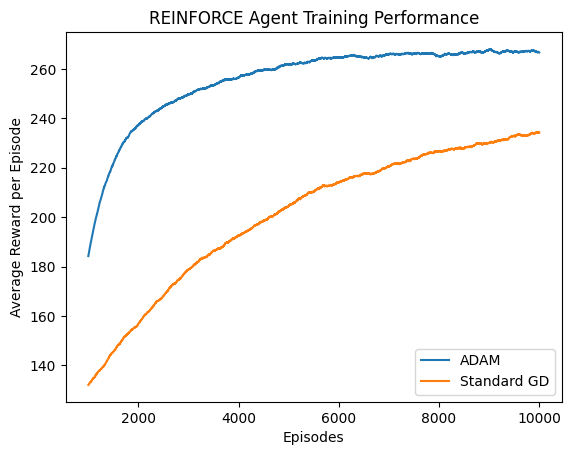

In [132]:
window_size = 1000
weights = np.ones(window_size) / window_size
moving_avg_adam = np.convolve(episode_reward_adam, weights, mode='valid')
episodes = np.arange(window_size, len(episode_reward) + 1)
plt.plot(episodes, moving_avg_adam)
plt.plot(episodes, moving_avg)
plt.legend(['ADAM','Standard GD'])
plt.xlabel('Episodes')
plt.ylabel('Average Reward per Episode')
plt.title('REINFORCE Agent Training Performance')

look at the weights of the model that REINFORCE USES 

In [133]:
print(r_agent_adam.weights)


[-2.36783528e+01  2.22447434e-01 -1.53592644e-01 -9.83043670e-02
 -1.12497392e-01 -3.15653448e-01 -2.15873798e-01 -1.92103289e-01
  5.80869243e-02  9.81787642e-02  2.84720009e-01  5.20504085e-02
  1.38847317e-02  9.91858797e-02  1.54791030e+01]
